In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_column', None)

data_path = './../data/nba_logreg.csv'
df = pd.read_csv(data_path)

In [3]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

def preprocessing(data, method=None):
    data = data.drop(['Name'], axis=1)
    data.loc[:, '3P%'] = data.loc[:, '3P%'].fillna(0)
    data = data.drop_duplicates()
    
    if method == 'oversample':
        ros = RandomOverSampler(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = ros.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)
    elif method == 'undersample':
        rus = RandomUnderSampler(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = rus.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)
    elif method == 'smote':
        sm = SMOTE(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = sm.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)
    
    return data

In [4]:
data_preprocessed = preprocessing(df, method='smote')
data_preprocessed

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,36,27.400000,7.400000,2.600000,7.600000,34.700000,0.5,2.100000,25.000000,1.600000,2.300000,69.900000,0.700000,3.400000,4.100000,1.900000,0.400000,0.400000,1.300000,0.0
1,35,26.900000,7.200000,2.000000,6.700000,29.600000,0.7,2.800000,23.500000,2.600000,3.400000,76.500000,0.500000,2.000000,2.400000,3.700000,1.100000,0.500000,1.600000,0.0
2,74,15.300000,5.200000,2.000000,4.700000,42.200000,0.4,1.700000,24.400000,0.900000,1.300000,67.000000,0.500000,1.700000,2.200000,1.000000,0.500000,0.300000,1.000000,0.0
3,58,11.600000,5.700000,2.300000,5.500000,42.600000,0.1,0.500000,22.600000,0.900000,1.300000,68.900000,1.000000,0.900000,1.900000,0.800000,0.600000,0.100000,1.000000,1.0
4,48,11.500000,4.500000,1.600000,3.000000,52.400000,0.0,0.100000,0.000000,1.300000,1.900000,67.400000,1.000000,1.500000,2.500000,0.300000,0.300000,0.400000,0.800000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,43,17.022340,3.930091,1.500000,3.930091,38.349544,0.0,0.082523,0.000000,0.947568,1.247568,72.214438,0.352432,1.282523,1.634954,2.830091,0.569909,0.217477,1.565046,0.0
1644,74,20.360644,6.633481,2.577827,5.489135,46.820846,0.0,0.122173,0.000000,1.516740,1.955654,79.210423,0.850221,1.777827,2.628048,2.310423,0.866519,0.177827,1.522173,0.0
1645,47,16.909071,5.223929,2.009571,4.438286,44.532499,0.3,0.990429,27.358429,0.909571,1.314357,71.956428,0.971286,2.537786,3.509071,0.767000,0.509571,0.476071,0.828714,0.0
1646,42,7.910078,2.039994,0.900000,2.139994,41.950043,0.0,0.000000,0.000000,0.269997,0.509991,51.399942,0.720012,1.100029,1.850043,0.569997,0.200000,0.160006,0.400000,0.0


In [77]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import KFold

def score_classifier(dataset,classifier,labels, folds=3, verbose=True):
    
    """
    This function takes in a dataset, classifier and labels and returns the mean confusion matrix, recall, precision, accuracy and f1 score
    for the classifier using KFold cross validation with the number of folds specified by the user

    Parameters:
    dataset: pandas dataframe
    classifier: sklearn classifier
    labels: pandas series
    folds: int

    Returns:
    dict: dictionary containing mean confusion matrix, recall, precision, accuracy and f1 score
    """

    kf = KFold(n_splits=folds,random_state=50,shuffle=True)
    confusion_mat_list = []
    recall_list = []
    precision_list = []
    accuracy_list = []
    f1_list = []

    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset.iloc[training_ids]
        training_labels = labels.iloc[training_ids]
        test_set = dataset.iloc[test_ids]
        test_labels = labels.iloc[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)

        confusion_mat = confusion_matrix(test_labels,predicted_labels)
        recall = recall_score(test_labels, predicted_labels)
        precision = precision_score(test_labels, predicted_labels)
        accuracy = classifier.score(test_set, test_labels)
        f1 = 2 * (precision * recall) / (precision + recall)

        recall_list.append(recall)
        precision_list.append(precision)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        confusion_mat_list.append(confusion_mat)

    recall = np.mean(recall_list)
    precision = np.mean(precision_list)
    accuracy = np.mean(accuracy_list)
    f1 = np.mean(f1_list)
    confusion_mat = np.mean(confusion_mat_list,axis=0).astype(int)
    confusion_mat_df = pd.DataFrame(confusion_mat,columns=['Predicted 0','Predicted 1'],index=['Actual 0','Actual 1'])

    if verbose:
        print(f"confusion_mat: \n {confusion_mat_df}")
        print(f"recall:{recall}")
        print(f"precision:{precision}")
        print(f"accuracy:{accuracy}")
        print(f"f1:{f1}")
    return {'confusion_mat':confusion_mat,'recall':recall,'precision':precision,'accuracy':accuracy,'f1':f1, 'classifier':classifier}


In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


target = 'TARGET_5Yrs'
balancer_method = None

model = LogisticRegression(C=0.1, solver='liblinear')
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

data_preprocessed = preprocessing(df, method=balancer_method)
scores = score_classifier(data_preprocessed.drop(target, axis=1), model, data_preprocessed[target], folds=5)


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           53           47
Actual 1           30          134
recall:0.8173592458961302
precision:0.7398428280842533
accuracy:0.7085827776989644
f1:0.7760403921005776


In [91]:
balancer_method = [None, 'undersample', 'oversample', 'smote']

model = LogisticRegression(C=0.1, solver='liblinear')
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

scores_blance_method = []
for method in balancer_method:
    data_preprocessed = preprocessing(df, method=method)
    scores = score_classifier(data_preprocessed.drop(target, axis=1), model, data_preprocessed[target], folds=5, verbose=False)
    scores_blance_method.append(scores)

scores_blance_method = pd.DataFrame(scores_blance_method)
scores_blance_method['balancer_method'] = balancer_method
scores_blance_method.sort_values(by=['recall', 'f1'], ascending=False)

,confusion_mat,recall,precision,accuracy,f1,classifier,balancer_method
0,"[[53, 47], [30, 134]]",0.817359,0.739843,0.708583,0.776040,"LogisticRegression(C=0.1, solver='liblinear')",None
2,"[[118, 46], [54, 110]]",0.667833,0.704479,0.692965,0.684235,"LogisticRegression(C=0.1, solver='liblinear')",oversample
3,"[[118, 46], [56, 108]]",0.660644,0.704463,0.690533,0.680147,"LogisticRegression(C=0.1, solver='liblinear')",smote
1,"[[72, 28], [34, 66]]",0.653543,0.696550,0.685557,0.673532,"LogisticRegression(C=0.1, solver='liblinear')",undersample


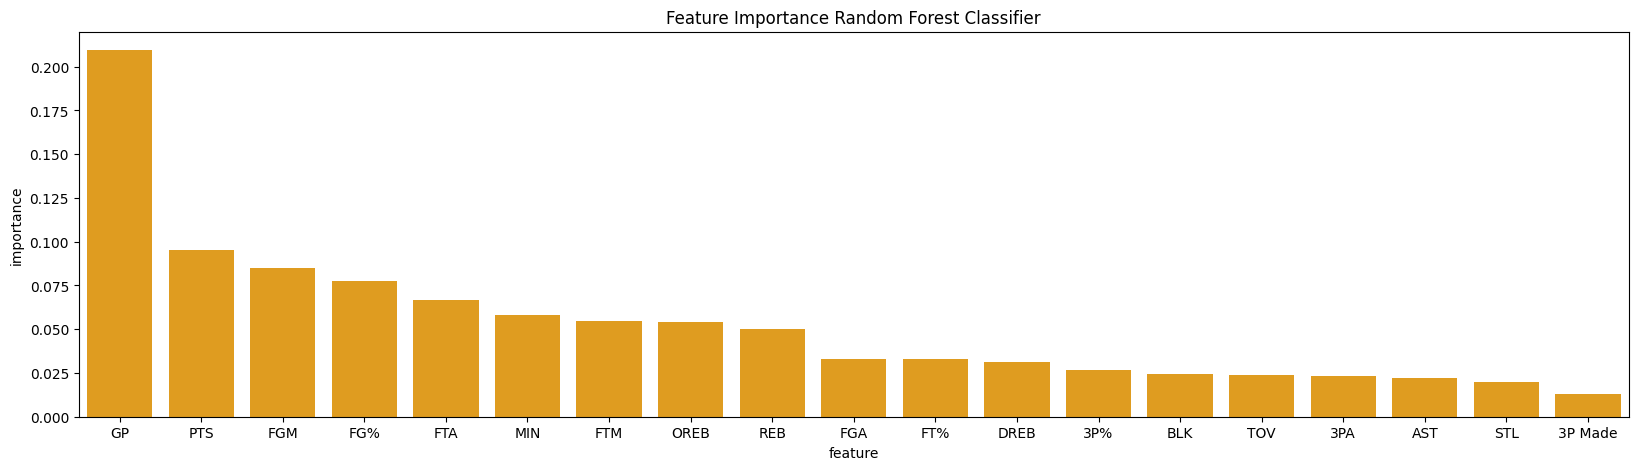

In [60]:
from sklearn.ensemble import RandomForestClassifier

target = 'TARGET_5Yrs'
balancer_method = None

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

data_preprocessed = preprocessing(df, method=balancer_method)
pipeline.fit(data_preprocessed.drop(target, axis=1), data_preprocessed[target])

feature_importance_rf = pd.DataFrame({'feature': data_preprocessed.drop(target, axis=1).columns, 'importance': pipeline.named_steps['model'].feature_importances_})
plt.figure(figsize=(20, 5))
sns.barplot(x='feature', y='importance', data=feature_importance_rf.sort_values(by='importance', ascending=False), color='orange')
plt.title('Feature Importance Random Forest Classifier')
plt.show()


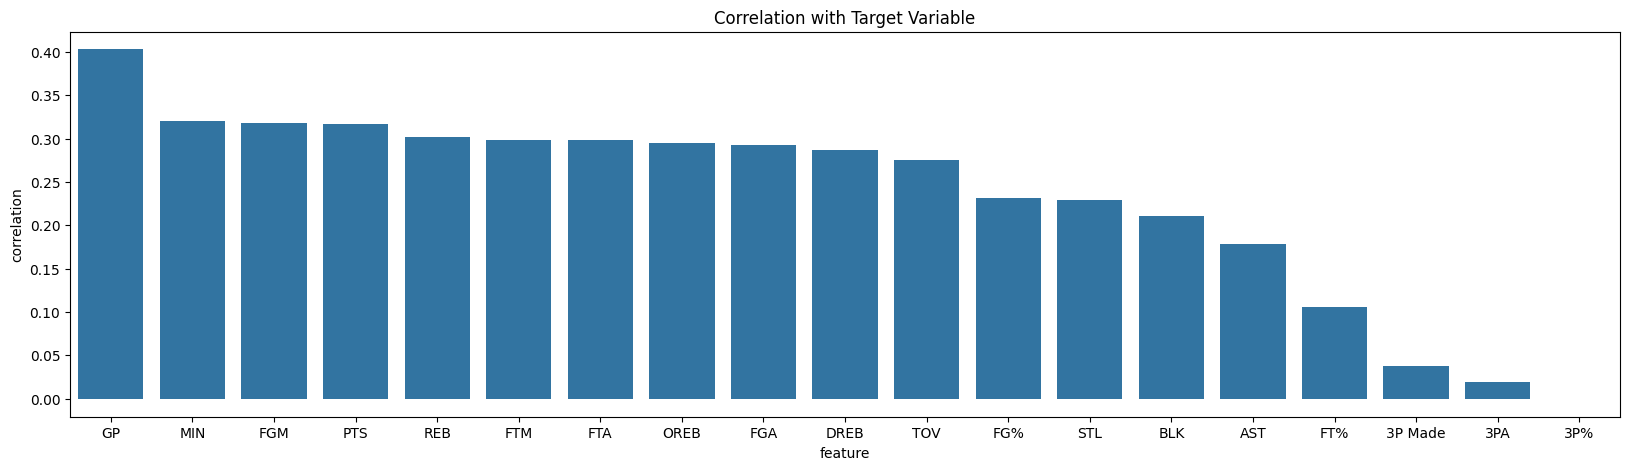

In [54]:
target = 'TARGET_5Yrs'
balancer_method = None

data_preprocessed = preprocessing(df, method=balancer_method)

correlation_matrix_target = data_preprocessed.corr()[target].sort_values(ascending=False)
correlation_matrix_target = correlation_matrix_target.drop(target)
correlation_matrix_target = pd.DataFrame({'feature': correlation_matrix_target.index, 'correlation': correlation_matrix_target.values})
plt.figure(figsize=(20, 5))
sns.barplot(x='feature', y='correlation', data=correlation_matrix_target.sort_values(by='correlation', ascending=False))
plt.title('Correlation with Target Variable')
plt.show()

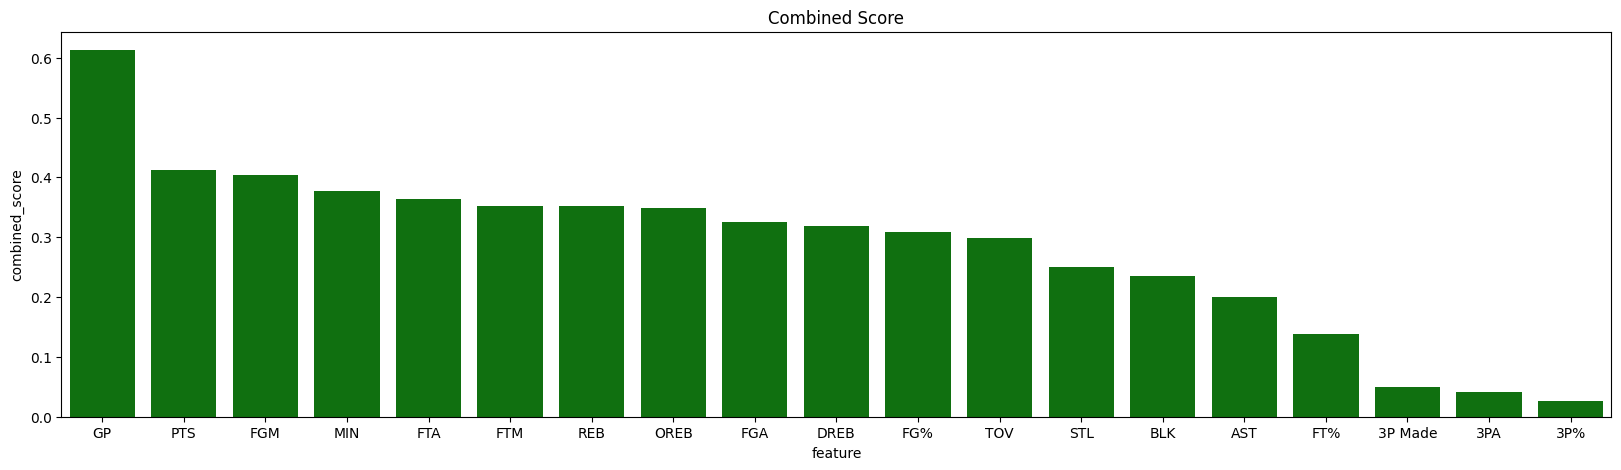

In [61]:
combined_df = correlation_matrix_target.merge(feature_importance_rf, on='feature')

combined_df['combined_score'] = combined_df['correlation'] + combined_df['importance']
plt.figure(figsize=(20, 5))
sns.barplot(x='feature', y='combined_score', data=combined_df.sort_values(by='combined_score', ascending=False), color='green')
plt.title('Combined Score')
plt.show()

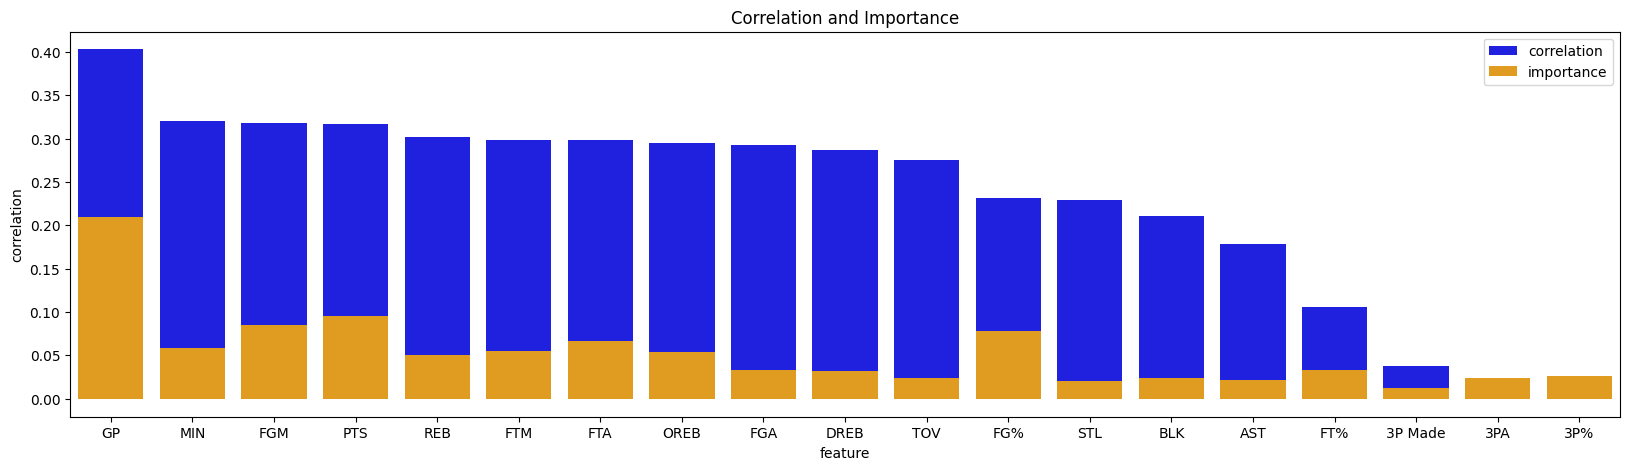

In [62]:
plt.figure(figsize=(20, 5))
sns.barplot(x='feature', y='correlation', data=correlation_matrix_target.sort_values(by='correlation', ascending=False), color='blue', label='correlation')
sns.barplot(x='feature', y='importance', data=feature_importance_rf.sort_values(by='importance', ascending=False), color='orange', label='importance')
plt.title('Correlation and Importance')
plt.show()

In [85]:
# feature selection : random forest

target = 'TARGET_5Yrs'
balancer_method = None

features_number = range(1, 20)

model = LogisticRegression(C=0.1, solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method)

scores_features_number = []
for number in features_number:
    features_selected = feature_importance_rf.sort_values(by='importance', ascending=False).head(number)['feature'].values
    scores = score_classifier(data_preprocessed[features_selected[:number]], model, data_preprocessed[target], folds=5, verbose=False)
    scores_features_number.append(scores)

scores_features_number = pd.DataFrame(scores_features_number)
scores_features_number['features_number'] = features_number
scores_features_number.sort_values(by=['recall', 'f1'], ascending=False)




,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
0,"[[36, 64], [19, 145]]",0.883783,0.692918,0.685206,0.776392,"LogisticRegression(C=0.1, solver='liblinear')",1
1,"[[41, 59], [22, 142]]",0.861140,0.706246,0.692002,0.775632,"LogisticRegression(C=0.1, solver='liblinear')",2
2,"[[41, 59], [23, 141]]",0.858600,0.704248,0.688986,0.773309,"LogisticRegression(C=0.1, solver='liblinear')",3
6,"[[46, 54], [26, 138]]",0.836691,0.717720,0.695015,0.772184,"LogisticRegression(C=0.1, solver='liblinear')",7
7,"[[50, 50], [27, 137]]",0.834557,0.731916,0.707828,0.779455,"LogisticRegression(C=0.1, solver='liblinear')",8
5,"[[46, 54], [27, 137]]",0.834238,0.717923,0.694263,0.771217,"LogisticRegression(C=0.1, solver='liblinear')",6
3,"[[45, 55], [27, 137]]",0.832769,0.712751,0.688977,0.767753,"LogisticRegression(C=0.1, solver='liblinear')",4
4,"[[46, 54], [27, 137]]",0.831956,0.717160,0.692754,0.769949,"LogisticRegression(C=0.1, solver='liblinear')",5
8,"[[50, 50], [28, 136]]",0.824726,0.728676,0.701044,0.773269,"LogisticRegression(C=0.1, solver='liblinear')",9
9,"[[51, 49], [29, 135]]",0.823701,0.731850,0.703288,0.774327,"LogisticRegression(C=0.1, solver='liblinear')",10


In [86]:
scores_features_number.sort_values(by=['f1'], ascending=False)

,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
7,"[[50, 50], [27, 137]]",0.834557,0.731916,0.707828,0.779455,"LogisticRegression(C=0.1, solver='liblinear')",8
16,"[[53, 47], [29, 135]]",0.818594,0.739559,0.708588,0.776407,"LogisticRegression(C=0.1, solver='liblinear')",17
0,"[[36, 64], [19, 145]]",0.883783,0.692918,0.685206,0.776392,"LogisticRegression(C=0.1, solver='liblinear')",1
18,"[[53, 47], [30, 134]]",0.817359,0.739843,0.708583,0.776040,"LogisticRegression(C=0.1, solver='liblinear')",19
1,"[[41, 59], [22, 142]]",0.861140,0.706246,0.692002,0.775632,"LogisticRegression(C=0.1, solver='liblinear')",2
17,"[[53, 47], [30, 134]]",0.816069,0.739717,0.707831,0.775338,"LogisticRegression(C=0.1, solver='liblinear')",18
9,"[[51, 49], [29, 135]]",0.823701,0.731850,0.703288,0.774327,"LogisticRegression(C=0.1, solver='liblinear')",10
2,"[[41, 59], [23, 141]]",0.858600,0.704248,0.688986,0.773309,"LogisticRegression(C=0.1, solver='liblinear')",3
8,"[[50, 50], [28, 136]]",0.824726,0.728676,0.701044,0.773269,"LogisticRegression(C=0.1, solver='liblinear')",9
6,"[[46, 54], [26, 138]]",0.836691,0.717720,0.695015,0.772184,"LogisticRegression(C=0.1, solver='liblinear')",7


In [100]:
# model search - feature selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

model = LogisticRegression(C=0.1, solver='liblinear')
pipeline = Pipeline(steps=[('model', model)])


score = score_classifier(X, pipeline, y, folds=5, verbose=False)
score['model'] = 'LogisticRegression'

score


{'confusion_mat': array([[ 36,  64],
        [ 19, 145]]),
 'recall': 0.8837826520122094,
 'precision': 0.6929183592767144,
 'accuracy': 0.6852064122570577,
 'f1': 0.7763916790471,
 'classifier': Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))]),
 'model': 'LogisticRegression'}

In [87]:
# feature selection : correlation

target = 'TARGET_5Yrs'
balancer_method = None

features_number = range(1, 20)

model = LogisticRegression(C=0.1, solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method)

scores_features_number = []
for number in features_number:
    features_selected = correlation_matrix_target.sort_values(by='correlation', ascending=False).head(number)['feature'].values
    scores = score_classifier(data_preprocessed[features_selected[:number]], model, data_preprocessed[target], folds=5, verbose=False)
    scores_features_number.append(scores)

scores_features_number = pd.DataFrame(scores_features_number)
scores_features_number['features_number'] = features_number
scores_features_number.sort_values(by=['recall', 'f1'], ascending=False)


,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
0,"[[36, 64], [19, 145]]",0.883783,0.692918,0.685206,0.776392,"LogisticRegression(C=0.1, solver='liblinear')",1
1,"[[38, 62], [20, 144]]",0.878168,0.699579,0.690489,0.778302,"LogisticRegression(C=0.1, solver='liblinear')",2
8,"[[43, 57], [21, 143]]",0.871370,0.716554,0.705555,0.785391,"LogisticRegression(C=0.1, solver='liblinear')",9
4,"[[43, 57], [21, 143]]",0.870936,0.714302,0.703308,0.784128,"LogisticRegression(C=0.1, solver='liblinear')",5
2,"[[41, 59], [21, 143]]",0.870562,0.707810,0.697268,0.780261,"LogisticRegression(C=0.1, solver='liblinear')",3
3,"[[42, 58], [21, 143]]",0.869511,0.711183,0.700287,0.781918,"LogisticRegression(C=0.1, solver='liblinear')",4
9,"[[44, 56], [21, 143]]",0.867754,0.717037,0.704801,0.784270,"LogisticRegression(C=0.1, solver='liblinear')",10
5,"[[43, 57], [21, 143]]",0.867452,0.712578,0.700295,0.781646,"LogisticRegression(C=0.1, solver='liblinear')",6
6,"[[43, 57], [22, 142]]",0.866217,0.713629,0.701044,0.781754,"LogisticRegression(C=0.1, solver='liblinear')",7
10,"[[43, 57], [22, 142]]",0.865269,0.715306,0.701793,0.782062,"LogisticRegression(C=0.1, solver='liblinear')",11


In [88]:
scores_features_number.sort_values(by=['f1'], ascending=False)


,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
8,"[[43, 57], [21, 143]]",0.871370,0.716554,0.705555,0.785391,"LogisticRegression(C=0.1, solver='liblinear')",9
9,"[[44, 56], [21, 143]]",0.867754,0.717037,0.704801,0.784270,"LogisticRegression(C=0.1, solver='liblinear')",10
4,"[[43, 57], [21, 143]]",0.870936,0.714302,0.703308,0.784128,"LogisticRegression(C=0.1, solver='liblinear')",5
10,"[[43, 57], [22, 142]]",0.865269,0.715306,0.701793,0.782062,"LogisticRegression(C=0.1, solver='liblinear')",11
3,"[[42, 58], [21, 143]]",0.869511,0.711183,0.700287,0.781918,"LogisticRegression(C=0.1, solver='liblinear')",4
6,"[[43, 57], [22, 142]]",0.866217,0.713629,0.701044,0.781754,"LogisticRegression(C=0.1, solver='liblinear')",7
5,"[[43, 57], [21, 143]]",0.867452,0.712578,0.700295,0.781646,"LogisticRegression(C=0.1, solver='liblinear')",6
2,"[[41, 59], [21, 143]]",0.870562,0.707810,0.697268,0.780261,"LogisticRegression(C=0.1, solver='liblinear')",3
7,"[[43, 57], [22, 142]]",0.864962,0.711771,0.698771,0.780109,"LogisticRegression(C=0.1, solver='liblinear')",8
1,"[[38, 62], [20, 144]]",0.878168,0.699579,0.690489,0.778302,"LogisticRegression(C=0.1, solver='liblinear')",2


In [89]:
# feature selection : combined score

target = 'TARGET_5Yrs'
balancer_method = None

features_number = range(1, 20)

model = LogisticRegression(C=0.1, solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method)

scores_features_number = []
for number in features_number:
    features_selected = combined_df.sort_values(by='combined_score', ascending=False).head(number)['feature'].values
    scores = score_classifier(data_preprocessed[features_selected[:number]], model, data_preprocessed[target], folds=5, verbose=False)
    scores_features_number.append(scores)

scores_features_number = pd.DataFrame(scores_features_number)
scores_features_number['features_number'] = features_number
scores_features_number.sort_values(by=['recall', 'f1'], ascending=False)

,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
0,"[[36, 64], [19, 145]]",0.883783,0.692918,0.685206,0.776392,"LogisticRegression(C=0.1, solver='liblinear')",1
8,"[[43, 57], [21, 143]]",0.871370,0.716554,0.705555,0.785391,"LogisticRegression(C=0.1, solver='liblinear')",9
5,"[[43, 57], [21, 143]]",0.869693,0.712762,0.701796,0.782868,"LogisticRegression(C=0.1, solver='liblinear')",6
3,"[[42, 58], [21, 143]]",0.869511,0.711183,0.700287,0.781918,"LogisticRegression(C=0.1, solver='liblinear')",4
4,"[[42, 58], [21, 143]]",0.868531,0.711888,0.700295,0.781833,"LogisticRegression(C=0.1, solver='liblinear')",5
9,"[[44, 56], [21, 143]]",0.867754,0.717037,0.704801,0.784270,"LogisticRegression(C=0.1, solver='liblinear')",10
6,"[[43, 57], [22, 142]]",0.866217,0.713629,0.701044,0.781754,"LogisticRegression(C=0.1, solver='liblinear')",7
7,"[[43, 57], [22, 142]]",0.864962,0.711771,0.698771,0.780109,"LogisticRegression(C=0.1, solver='liblinear')",8
1,"[[41, 59], [22, 142]]",0.861140,0.706246,0.692002,0.775632,"LogisticRegression(C=0.1, solver='liblinear')",2
2,"[[41, 59], [23, 141]]",0.858600,0.704248,0.688986,0.773309,"LogisticRegression(C=0.1, solver='liblinear')",3


In [90]:
scores_features_number.sort_values(by=['f1'], ascending=False)

,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
8,"[[43, 57], [21, 143]]",0.871370,0.716554,0.705555,0.785391,"LogisticRegression(C=0.1, solver='liblinear')",9
9,"[[44, 56], [21, 143]]",0.867754,0.717037,0.704801,0.784270,"LogisticRegression(C=0.1, solver='liblinear')",10
5,"[[43, 57], [21, 143]]",0.869693,0.712762,0.701796,0.782868,"LogisticRegression(C=0.1, solver='liblinear')",6
3,"[[42, 58], [21, 143]]",0.869511,0.711183,0.700287,0.781918,"LogisticRegression(C=0.1, solver='liblinear')",4
4,"[[42, 58], [21, 143]]",0.868531,0.711888,0.700295,0.781833,"LogisticRegression(C=0.1, solver='liblinear')",5
6,"[[43, 57], [22, 142]]",0.866217,0.713629,0.701044,0.781754,"LogisticRegression(C=0.1, solver='liblinear')",7
7,"[[43, 57], [22, 142]]",0.864962,0.711771,0.698771,0.780109,"LogisticRegression(C=0.1, solver='liblinear')",8
0,"[[36, 64], [19, 145]]",0.883783,0.692918,0.685206,0.776392,"LogisticRegression(C=0.1, solver='liblinear')",1
18,"[[53, 47], [30, 134]]",0.817359,0.739843,0.708583,0.776040,"LogisticRegression(C=0.1, solver='liblinear')",19
14,"[[53, 47], [29, 135]]",0.818656,0.738584,0.707808,0.775784,"LogisticRegression(C=0.1, solver='liblinear')",15


In [92]:
target = 'TARGET_5Yrs'
balancer_method = None

features_number = 9

model = LogisticRegression(C=0.1, solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method)

features_selected = combined_df.sort_values(by='combined_score', ascending=False).head(number)['feature'].values
scores = score_classifier(data_preprocessed[features_selected[:number]], model, data_preprocessed[target], folds=5, verbose=False)


print(f"features_selected: {features_selected}")

features_selected: ['GP' 'PTS' 'FGM' 'MIN' 'FTA' 'FTM' 'REB' 'OREB' 'FGA' 'DREB' 'FG%' 'TOV'
 'STL' 'BLK' 'AST' 'FT%' '3P Made' '3PA' '3P%']
